In [1]:
%matplotlib notebook 

import numpy as np
import matplotlib.pyplot as plt
from kosmos.apextract import _gaus
import kosmos


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



<IPython.core.display.Javascript object>


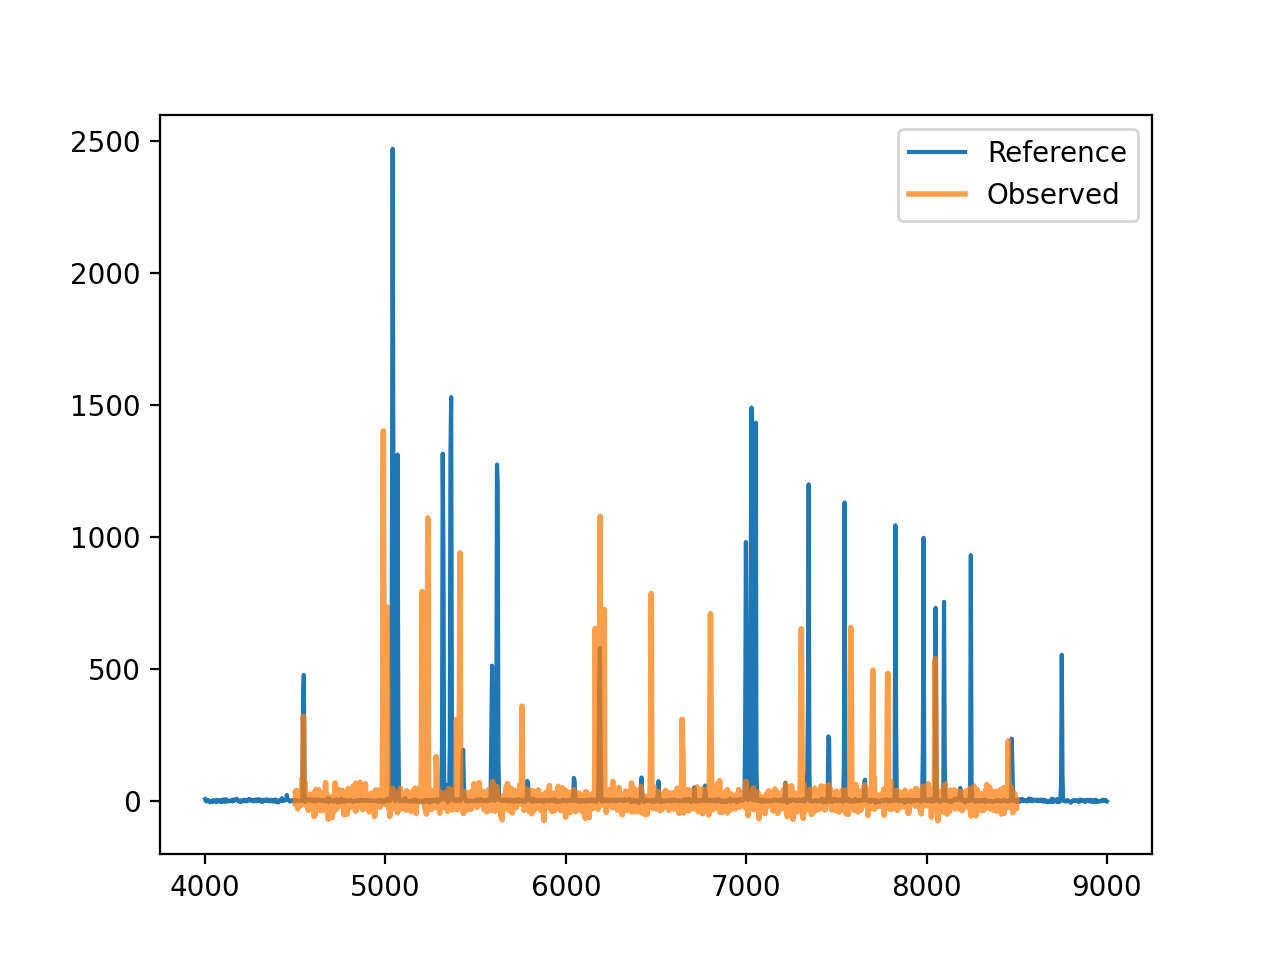

In [23]:
# generate some fake arc lamp spectra 

wav = np.append(np.logspace(np.log10(4500), np.log10(7000), 1024), 
               np.linspace(7001, 8500, 1024))

pix = np.arange(len(wav))

Nlines = 30
lines = np.random.random(size=Nlines)*4000 + 4500
peaks = np.random.random(size=Nlines) * 1000

flux = np.zeros(2048)
for k in range(Nlines):
    flux = flux + _gaus(wav, peaks[k], 0, lines[k], 2)

# do transformation for ref spectrum
flux2 = np.interp(np.linspace(4500,8500,2048), wav, flux)

# add some gaussian noise to the observation
flux = flux+np.random.normal(loc=0, scale=25, size=2048)

# Here's the TRUTH you would have on hand, either from observatory or a previous reduction
# it spans a larger wavelength range, and has a few extra random lines in it
wav_ref = np.linspace(4000,9000,1280)
flux_ref = np.interp(wav_ref, wav, flux2) * 2  # down-sample the library spectrum
flux_ref = flux_ref + np.random.normal(loc=0, scale=3, size=len(flux_ref))

# put some extra small lines in
elines = 10
for k in range(elines):
    flux_ref = flux_ref + _gaus(wav_ref, np.random.random(size=1)*100, 0, 
                        np.random.random(size=1)*5000+4000, 2)
# put at least 1 major line outside the observed spectrum too
flux_ref = flux_ref + _gaus(wav_ref, 555, 0, 8750, 2)

plt.plot(wav_ref, flux_ref, label='Reference')

# the observation is (pix, flux)
# and if you just linearly shift/scaled the trace into the wavelegnth range:
plt.plot(np.linspace(4500,8500,2048), flux, lw=2, alpha=0.75, label='Observed')
plt.legend()

<IPython.core.display.Javascript object>


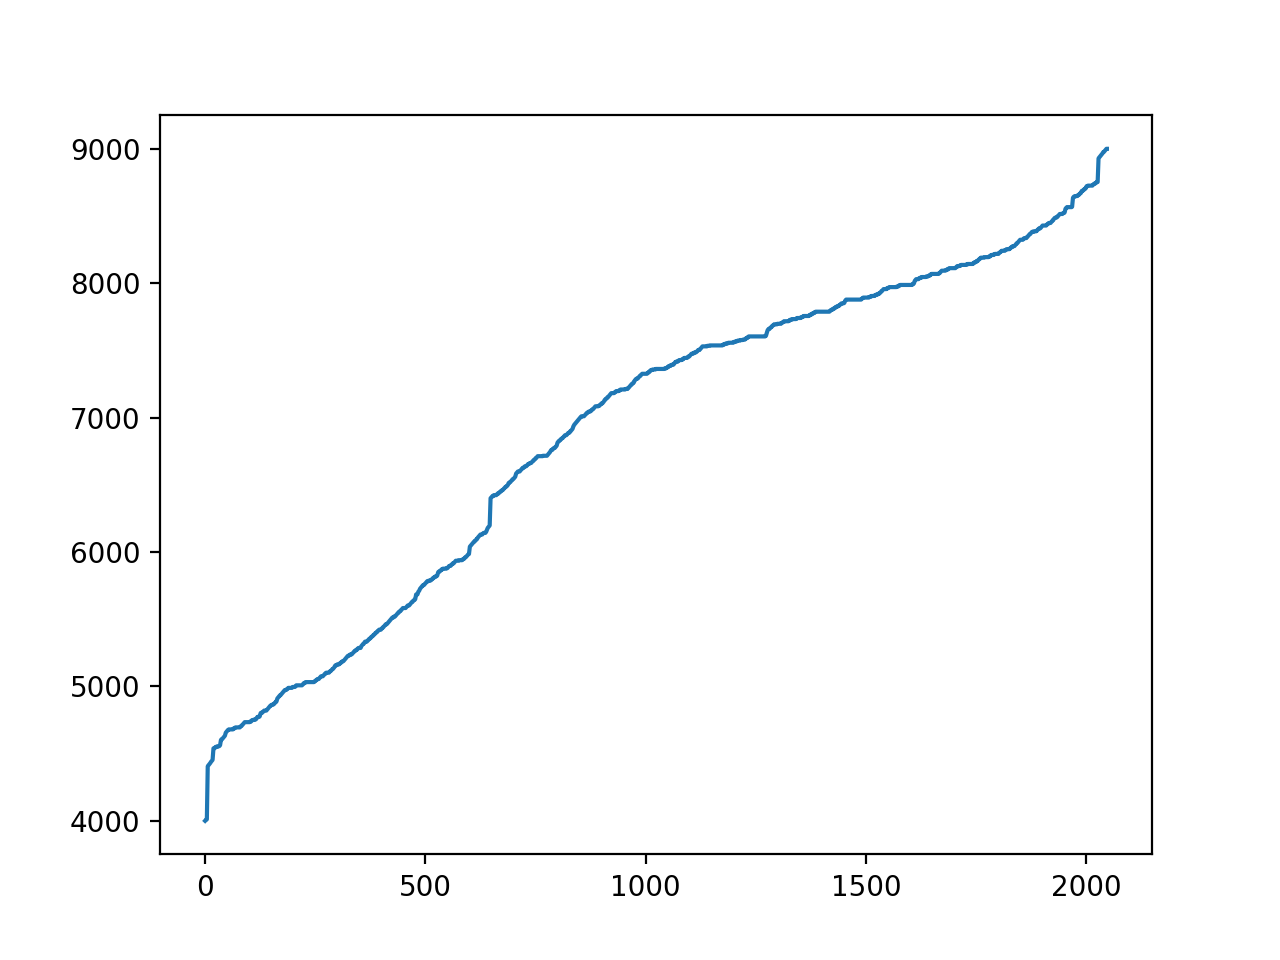

In [25]:
# do the actual DTW matching
wav_guess = kosmos.dtwalign(pix, flux, wav_ref, flux_ref)
plt.plot(pix,wav_guess)

<IPython.core.display.Javascript object>


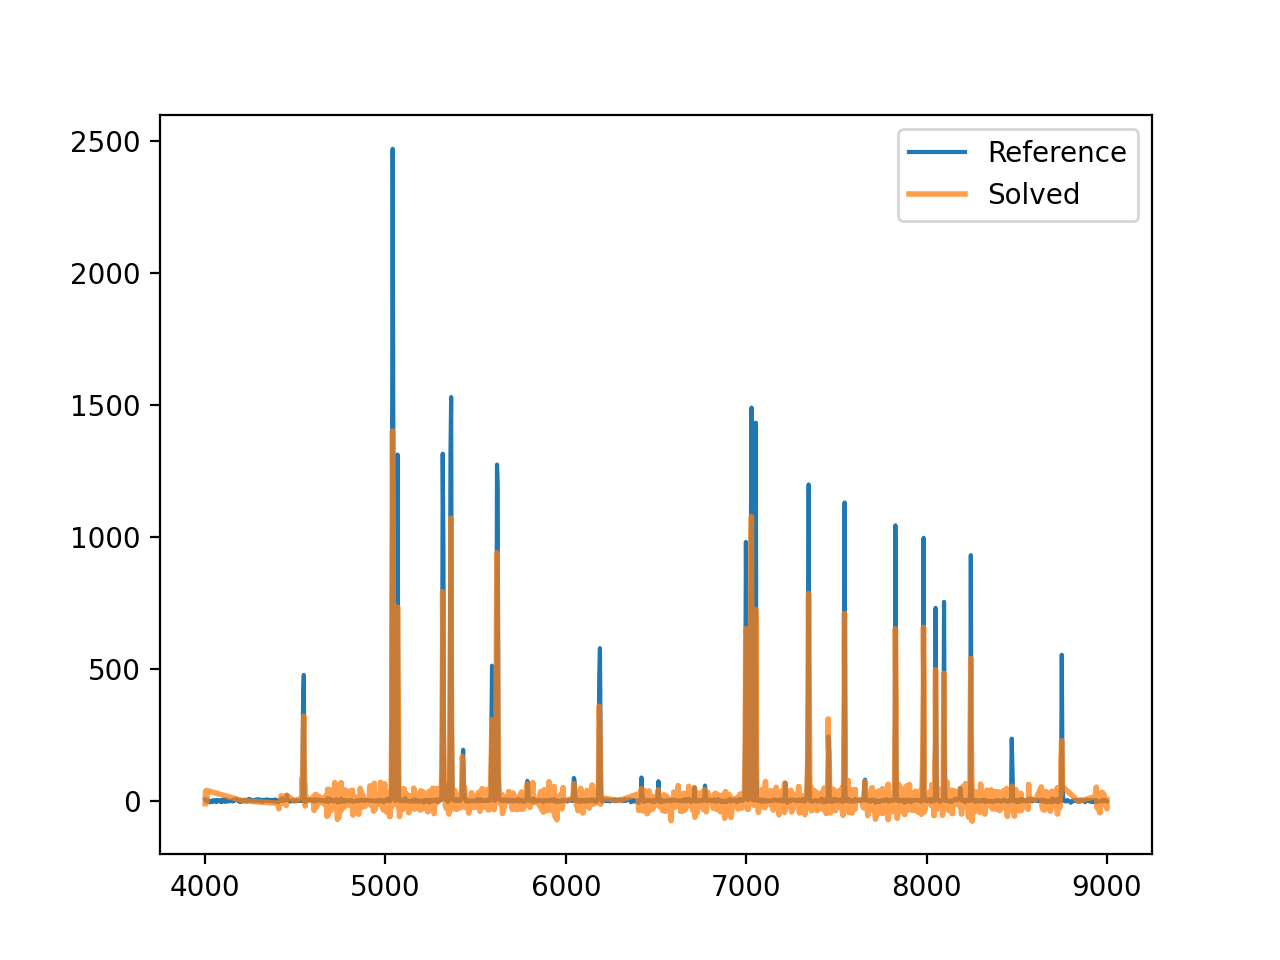

In [26]:
plt.plot(wav_ref, flux_ref, label='Reference')
plt.plot(wav_guess, flux, label='Solved', alpha=0.75, lw=2)
plt.legend()

So it works OK when the reference spectrum is wider than than the observed spectrum. I think we could figure this out using a gradient in the solution - dWave/dPixel gets steeper than we reasonably expect.

Things go a bit sideways if the observation isn't contained fully within the reference...  not impossible, but harder.

My takeaway is that with perhaps one good refrence spectrum (which you could probably stitch together over the entire observing range), you could probably use DTW to get an approx wavelength solution VERY easily.

This could be greatly improved using
- any basic prediction of the wavelenth solution (lets you trim the reference close to the limits)
- an iterative step where the fit quality/limits are considered, drop any points w/ bad fits or low information (e.g. big stretches between emission lines), and then maybe run a spline through the good bits